In [1]:
import pandas as pd
import pickle

import matplotlib.pyplot as plt

In [2]:
with open('df_with_patch_object.pickle', 'rb') as f:
    patch_responses = pickle.load(f)

In [3]:
import base64
import nltk

def get_newest_message(email):
    while isinstance(email._payload, list):
        email = email._payload[0]
    return email.get_payload()

def extract_review(email):
    
    payload = get_newest_message(email)
    
    return ' '.join([line.strip() 
                for line in payload.split('\n') if not line.strip()=='' and not line.startswith('>')])

In [4]:
reviews = patch_responses[patch_responses['email'].notnull()][patch_responses['self_response'] == False]
reviews.drop(['self_response', 'Patch'], inplace=True, axis=1)

<ipython-input-4-870f016a55f3>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  reviews = patch_responses[patch_responses['email'].notnull()][patch_responses['self_response'] == False]


In [5]:
reviews.count()

Unnamed: 0         158200
patch_id           158200
response_author    158200
resp_parent        158200
resp_msg_id        158200
upstream            17293
response_is_bot    158200
bot_name            16077
patch_author       158200
responder          158200
email              158200
dtype: int64

In [6]:
reviews['payload'] = reviews['email'].map(extract_review)

In [7]:
reviews['email'][3].get_payload().split('\n')

['',
 'On 4/21/20 5:21 PM, Jason Gunthorpe wrote:',
 '> From: Jason Gunthorpe <jgg@mellanox.com>',
 '> ',
 '> The API is a bit complicated for the uses we actually have, and',
 '> disucssions for simplifying have come up a number of times.',
 '> ',
 '> This small series removes the customizable pfn format and simplifies the',
 '> return code of hmm_range_fault()',
 '> ',
 '> All the drivers are adjusted to process in the simplified format.',
 "> I would appreciated tested-by's for the two drivers, thanks!",
 '',
 'For nouveau you can add:',
 'Tested-by: Ralph Campbell <rcampbell@nvidia.com>',
 '',
 '']

In [8]:
reviews['payload'][3]

'On 4/21/20 5:21 PM, Jason Gunthorpe wrote: For nouveau you can add: Tested-by: Ralph Campbell <rcampbell@nvidia.com>'

In [9]:
reviews.drop('email', axis=1, inplace=True)

In [10]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import re

lemmatizer = WordNetLemmatizer() 
def lemmatize(text):
    
    #remove punctuation and numbers, switch to lowercase
    text = re.sub(r'[_\d,:+.!?\\-]+', '', text.lower())
    
    # lemmatize and return as one string
    return ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text)])

In [11]:
reviews.iloc[45]

Unnamed: 0                                                        66
patch_id                <000601d55d49$05878160$10968420$@emc.com.tw>
response_author        'Dmitry Torokhov' <dmitry.torokhov@gmail.com>
resp_parent             <000601d55d49$05878160$10968420$@emc.com.tw>
resp_msg_id                        <20190829182933.GD187474@dtor-ws>
upstream                                                         NaN
response_is_bot                                                False
bot_name                                                         NaN
patch_author           ('johnny.chuang', 'johnny.chuang@emc.com.tw')
responder          ("'dmitry torokhov'", 'dmitry.torokhov@gmail.c...
payload            Hi Johnny, On Wed, Aug 28, 2019 at 10:33:46AM ...
Name: 66, dtype: object

In [12]:
reviews['payload'].iloc[45]

'Hi Johnny, On Wed, Aug 28, 2019 at 10:33:46AM +0800, Johnny.Chuang wrote: We do not want to return error here, because it will abort probe, and then we will not be able to initiate firmware flash flow so we can attempt to recover the device. If you want to try you can change the ts->iap_mode before trying to register input device, but then you need to be very careful about registering and unregistering it later, after flashing or re-flashing firmware. Thanks. -- Dmitry'

In [13]:
lemmatize(reviews['payload'].iloc[45])

'hi johnny on wed aug at am johnnychuang wrote we do not want to return error here because it will abort probe and then we will not be able to initiate firmware flash flow so we can attempt to recover the device if you want to try you can change the t > iapmode before trying to register input device but then you need to be very careful about registering and unregistering it later after flashing or reflashing firmware thanks dmitry'

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

vectorizer = TfidfVectorizer(max_df=0.5, max_features=80,
                                 min_df=2, stop_words='english',
                                 use_idf=True)
subset_reviews = reviews[:10000]
data_corpus = subset_reviews['payload'].map(lemmatize)

X = vectorizer.fit_transform(data_corpus) 

svd = TruncatedSVD(n_components=50)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X = lsa.fit_transform(X)

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
        int(explained_variance * 100)))

Explained variance of the SVD step: 95%


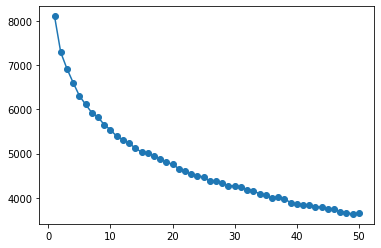

In [15]:
from sklearn.cluster import KMeans
sse = {}

for k in range(1, 51):
    kmeans = KMeans(n_clusters=k).fit(X)# , max_iter=1000
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.show()

In [16]:
num_clusters = 15

In [17]:
kmeans = KMeans(n_clusters=num_clusters).fit(X)

subset_reviews["clusters"] = kmeans.labels_

order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

for i in range(num_clusters):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: case add balbir change drivers fix http define linux debe
Cluster 1: add error file ha cast include hi make https http
Cluster 2: add applied case aug git change arch file error define
Cluster 3: add balbir bit perf cast cpu git listinfo cc http
Cluster 4: function add file case include cpu debe kernelorg https perf
Cluster 5: kernelorg http function list change code fix cc int listsinfradeadorg
Cluster 6: arch balbir add diff http include aug case int cast
Cluster 7: aug add diff cpu debe balbir cast function http include
Cluster 8: cc add arch debe aug error git function ha bit
Cluster 9: code add cpu bit arch aug git fix case file
Cluster 10: cast cc add case arch aug debe bit ha git
Cluster 11: add ha balbir bit applied hi patch fix include debe
Cluster 12: add define dev cpu debe fix http just linuxarmkernel int
Cluster 13: change add bit debe arch aug git error function file
Cluster 14: change cc code add cast listinfo balbir dev doe kernel


<ipython-input-17-fdc2aad25c38>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_reviews["clusters"] = kmeans.labels_


In [18]:
kmeans.inertia_

5028.995126852311

In [19]:
subset_reviews.groupby('clusters').size()

clusters
0      682
1     2051
2     1179
3      591
4      354
5      136
6      452
7      580
8      483
9      614
10     509
11     392
12     753
13     465
14     759
dtype: int64

In [20]:
def get_active_days(line):
    try:
        return (pd.to_datetime(line['Activity End']) - pd.to_datetime(line['Activity Start'])).days
    except:
        return None

def get_num_commits(Commits):
    try:
        return int(Commits)
    except:
        return None

developer_stats = pd.read_csv('developers_all.csv')
developer_stats['Active'] = developer_stats.apply(get_active_days, axis=1)
developer_stats['Name'] = developer_stats['Name'].str.lower()
developer_stats['Commits'] = developer_stats['Commits'].map(get_num_commits)

In [21]:
subset_reviews['Name'] = subset_reviews['response_author'].str.extract('(.*) <.*>')
subset_reviews['Name']

<ipython-input-21-95c10e78d4dc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_reviews['Name'] = subset_reviews['response_author'].str.extract('(.*) <.*>')


3         Ralph Campbell
8        Leon Romanovsky
10                   NaN
11          David Miller
12       Leon Romanovsky
              ...       
11507    Jason Gunthorpe
11508      Sagi Grimberg
11509      Sagi Grimberg
11510    Jason Gunthorpe
11511          Patchwork
Name: Name, Length: 10000, dtype: object

In [22]:
subset_reviews['Name'] = subset_reviews['response_author'].str.extract('(.*) <.*>')
subset_reviews = pd.merge(subset_reviews, developer_stats, on='Name', how='left')
subset_reviews.head()

<ipython-input-22-da660c55f6e5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_reviews['Name'] = subset_reviews['response_author'].str.extract('(.*) <.*>')


,Unnamed: 0,patch_id,response_author,resp_parent,resp_msg_id,upstream,response_is_bot,bot_name,patch_author,responder,...,Commits,Changed Lines,Lines Removed,Signoffs,Reviews,Test Credits,Test Credits Given,Report Credits,Report Credits Given,Active
0,3,<0-v1-4eb72686de3c+5062-hmm_no_flags_jgg@mella...,Ralph Campbell <rcampbell@nvidia.com>,<0-v1-4eb72686de3c+5062-hmm_no_flags_jgg@mella...,<17ce2fdc-4f9f-7772-c10c-6f339a4183e8@nvidia.com>,NaN,False,NaN,"('jason gunthorpe', 'jgg@ziepe.ca')","('ralph campbell', 'rcampbell@nvidia.com')",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8,<0-v1-a36d512e0a99+762-syz_dealloc_driver_jgg@...,Leon Romanovsky <leon@kernel.org>,<0-v1-a36d512e0a99+762-syz_dealloc_driver_jgg@...,<20200628080202.GB6281@unreal>,NaN,False,NaN,"('jason gunthorpe', 'jgg@nvidia.com')","('leon romanovsky', 'leon@kernel.org')",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10,<0-v1-a3e19ba593e0+f5-rds_gcc10%jgg@mellanox.com>,santosh.shilimkar@oracle.com,<0-v1-a3e19ba593e0+f5-rds_gcc10%jgg@mellanox.com>,<6ea2ccf7-6bea-3a00-2fe7-79c09c7cb782@oracle.com>,NaN,False,NaN,"('jason gunthorpe', 'jgg@ziepe.ca')","('', 'santosh.shilimkar@oracle.com')",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11,<0-v1-a3e19ba593e0+f5-rds_gcc10%jgg@mellanox.com>,David Miller <davem@davemloft.net>,<0-v1-a3e19ba593e0+f5-rds_gcc10%jgg@mellanox.com>,<20200415.123344.555133895779578194.davem@dave...,NaN,False,NaN,"('jason gunthorpe', 'jgg@ziepe.ca')","('david miller', 'davem@davemloft.net')",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12,<0-v1-ace813388969+48859-uverbs_poll_fix%jgg@m...,Leon Romanovsky <leon@kernel.org>,<0-v1-ace813388969+48859-uverbs_poll_fix%jgg@m...,<20200407051632.GL80989@unreal>,eb356e6dc15a30af604f052cd0e170450193c254,False,NaN,"('jason gunthorpe', 'jgg@ziepe.ca')","('leon romanovsky', 'leon@kernel.org')",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


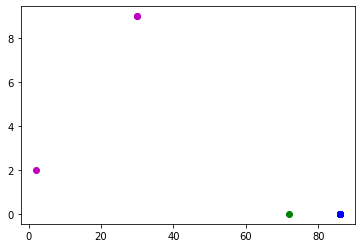

In [23]:
import itertools

fig, ax = plt.subplots()

colors = itertools.cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k'])
for i in range(num_clusters):
    plt.scatter(subset_reviews[subset_reviews['clusters']==i]['Commits'], 
            subset_reviews[subset_reviews['clusters']==i]['Reviews'], color=next(colors))
    